<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: spec2, pathloss step

<span style="color:red"> **Instruments Affected**</span>: NIRSpec 

Tested on CV3 data

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Testing Data Set](#data_ID) <br> [Run the JWST pipeline and assign_wcs validation tests](#pipeline_ID): [FS Full-Frame test](#FULLFRAME), [FS ALLSLITS test](#ALLSLITS), [MOS test](#MOS) <br> [About This Notebook](#about_ID)<br> [Results](#results) <br>

</div>

<a id="imports_ID"></a>
# Imports
The library imports relevant to this notebook are aready taken care of by importing PTT.

* astropy.io for opening fits files
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot

NOTE: This notebook assumes that the pipeline version to be tested is already installed and its environment is activated.

To be able to run this notebook you need to install nptt. 

If all goes well you will be able to import PTT.

[Top of Page](#title_ID)

In [1]:
import os
import subprocess
from glob import glob

import jwst
from jwst.pipeline.calwebb_detector1 import Detector1Pipeline
from jwst.assign_wcs.assign_wcs_step import AssignWcsStep
from jwst.msaflagopen.msaflagopen_step import MSAFlagOpenStep
from jwst.extract_2d.extract_2d_step import Extract2dStep
from jwst.srctype.srctype_step import SourceTypeStep
from jwst.flatfield.flat_field_step import FlatFieldStep
from jwst.pathloss.pathloss_step import PathLossStep
from jwst import datamodels

# The latest version of NPTT is installed in the requirements text file at:
# /jwst_validation_notebooks/environment.yml

# import NPTT
import nirspec_pipe_testing_tool as nptt

# To get data from Artifactory
from ci_watson.artifactory_helpers import get_bigdata


In [2]:
# VERSIONS

# print the jwst pipeline version
print("Using JWST pipeline version: ", jwst.__version__)

# Make sure that the version used is the right one

# to get the latest version from 'master' run:
# subprocess.run(['pip', 'install', 'git+https://github.com/spacetelescope/nirspec_pipe_testing_tool@master'])

latest_nptt_stable_version = '1.1.4'
nptt_version = nptt.__version__

if nptt_version != latest_nptt_stable_version:
    print("\n* WARNING - The code might break because the version used is not the latest stable version:")
    print("            Latest stable version is ", latest_nptt_stable_version)
    print("            Using NPTT version ", nptt_version)

Using JWST pipeline version:  0.18.2.dev3+g69f9c4f4

* WARNING - The code might break because the version used is not the latest stable version:
            Latest stable version is  1.1.4
            Using NPTT version  1.1.3


<a id="intro_ID"></a>
# Test Description

The NIRSpec team developed an implementation of the pathloss step and compared the output to the pipeline output for this step. We expected machine precision differences (about 10^-7) but due to rounding differences in interpolation methods we relaxed the difference threshold to 10^-6. 

For the test to be considered PASSED, every single slit (for FS data), slitlet (for MOS data) or slice (for IFU data) in the input file has to pass. If there is any failure, the whole test will be considered as FAILED. 

The code for this test for Fixed Slits (FS) can be obtained from: https://github.com/spacetelescope/nirspec_pipe_testing_tool/blob/master/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_fs_ps.py. There is a corresponding script for Multi Object Spectroscopy (MOS) and for Integral Field Unit (IFU) data. Each mode has a script for point source (ps) and for uniform source (uni).


Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/pathloss/description.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/pathloss


### Results

If the test **PASSED** this means that all slits, slitlets, or slices individually passed the test. However, if ony one individual slit (for FS data), slitlet (for MOS data) or slice (for IFU data) test failed, the whole test will be reported as **FAILED**.


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Spectral+GWCS+Information 


### Defining Term
Acronymns used un this notebook:

pipeline: calibration pipeline

spec2: spectroscopic calibration pipeline level 2b

PTT: NIRSpec pipeline testing tool (https://github.com/spacetelescope/nirspec_pipe_testing_tool)


[Top of Page](#title_ID)

<a id="pipeline_ID"></a>
# Run the JWST pipeline and pathloss validation tests

The pipeline can be run from the command line in two variants: full or per step.

Tu run the spec2 pipeline in full use the command: 

$ strun jwst.pipeline.Spec2Pipeline jwtest_rate.fits

Tu only run the pathloss step, use the command:

$ strun jwst.pathloss.PathLossStep jwtest_previous_step_output.fits


These options are also callable from a script with the testing environment active. The Python call for running the pipeline in full or by step are:

$\gt$ from jwst.pipeline.calwebb_spec2 import Spec2Pipeline

$\gt$ Spec2Pipeline.call(jwtest_rate.fits)
 
or
 
$\gt$ from jwst.pathloss import PathLossStep
 
$\gt$ PathLossStep.call(jwtest_previous_step_output.fits)


PTT can run the spec2 pipeline either in full or per step, as well as the imaging pipeline in full. In this notebook we will use PTT to run the pipeline and the validation tests. To run PTT, follow the directions in the corresponding repo page.

[Top of Page](#title_ID)

<a id="data_ID"></a>
# Testing Data Set

All testing data is from the CV3 campaign. We chose these files because this is our most complete data set, i.e. all modes and filter-grating combinations.

Data used was for testing was only FS and MOS, since extract_2d is skipped for IFU. Data sets are:
- FS_PRISM_CLEAR
- FS_FULLFRAME_G395H_F290LP
- FS_ALLSLITS_G140H_F100LP 
- MOS_G140M_LINE1 
- MOS_PRISM_CLEAR
- IFU_G395H_F290LP 
- IFU_PRISM_CLEAR


[Top of Page](#title_ID)

In [3]:
testing_data = {'fs_prism_clear':{
                                  'uncal_file_nrs1': 'fs_prism_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'fs_prism_nrs2_uncal.fits',
                                  'msa_shutter_config': None },
                
                'fs_fullframe_g395h_f290lp':{
                                  'uncal_file_nrs1': 'fs_fullframe_g35h_f290lp_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'fs_fullframe_g35h_f290lp_nrs2_uncal.fits',
                                  'msa_shutter_config': None },
                
                'fs_allslits_g140h_f100lp':{
                                  'uncal_file_nrs1': 'fs_allslits_g140h_f100lp_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'fs_allslits_g140h_f100lp_nrs2_uncal.fits',
                                  'msa_shutter_config': None },
                
                'mos_prism_clear':{
                                  'uncal_file_nrs1': 'mos_prism_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'mos_prism_nrs2_uncal.fits',
                                  'msa_shutter_config': 'V0030006000104_msa.fits' },
                
                'mos_g140m_f100lp':{
                                  'uncal_file_nrs1': 'mos_g140m_line1_NRS1_uncal.fits',
                                  'uncal_file_nrs2': 'mos_g140m_line1_NRS2_uncal.fits',  
                                  'msa_shutter_config': 'V8460001000101_msa.fits' },
                
                'ifu_prism_clear':{
                                  'uncal_file_nrs1': 'ifu_prism_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'ifu_prism_nrs2_uncal.fits',
                                  'msa_shutter_config': None },

                'ifu_g395h_f290lp':{
                                  'uncal_file_nrs1': 'ifu_g395h_f290lp_nrs1_uncal.fits',
                                  'uncal_file_nrs2': 'ifu_g395h_f290lp_nrs2_uncal.fits',
                                  'msa_shutter_config': None }

               }



In [4]:
# define function to pull data from Artifactory
def get_artifactory_file(data_set_dict, detector):
    """This function creates a list with all the files needed per detector to run the test.
    Args:
        data_set_dict: dictionary, contains inputs for a specific mode and configuration
        detector: string, either nrs1 or nrs2
    Returns:
        data: list, contains all files needed to run test
    """
    files2obtain = ['uncal_file_nrs1', 'msa_shutter_config']
    data = []
    for file in files2obtain:
        data_file = None
        try: 
            if '_nrs' in file and '2' in detector:
                file = file.replace('_nrs1', '_nrs2')

            data_file = get_bigdata('jwst_validation_notebooks',
                                         'validation_data',
                                         'nirspec_data', 
                                         data_set_dict[file])
        except TypeError:
            data.append(None)
            continue

        data.append(data_file)

    return data

Testing files for detector:  nrs1
Working with uncal_file:  /Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/pathloss/jwst_pathloss_nirspec_test/fs_prism_nrs1_uncal.fits


2021-01-22 16:15:36,041 - stpipe - WARNING - /Users/pena/anaconda3/envs/pipedev/lib/python3.8/site-packages/stdatamodels/validate.py:34: ValidationWarning: While validating meta.instrument.fixed_slit the following error occurred:
'FULL' is not one of ['S200A1', 'S200A2', 'S200B1', 'S400A1', 'S1600A1', 'NONE']

Failed validating 'enum' in schema:
    OrderedDict([('title', 'Name of fixed slit aperture used'),
                 ('type', 'string'),
                 ('enum',
                  ['S200A1',
                   'S200A2',
                   'S200B1',
                   'S400A1',
                   'S1600A1',
                   'NONE']),
                 ('fits_keyword', 'FXD_SLIT'),
                 ('blend_table', True)])

On instance:
    'FULL'
  warnings.warn(errmsg, ValidationWarning)

2021-01-22 16:15:36,776 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-01-22 16:15:36,777 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance c

2021-01-22 16:15:36,979 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0086.fits'.
2021-01-22 16:15:36,980 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0019.fits'.
2021-01-22 16:15:36,981 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_ipc_0011.fits'.
2021-01-22 16:15:36,981 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0018.fits'.
2021-01-22 16:15:36,982 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0010.fits'.
2021-01-22 16:15:36,983 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2021-01-22 16:15:

2021-01-22 16:15:39,302 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done
2021-01-22 16:15:39,385 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs1_uncal.fits>,).
2021-01-22 16:15:39,386 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/pathloss/jwst_pathloss_nirspec_test', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2021-01-22 16:15:39,400 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /Users/pena/crds_cache/refer

2021-01-22 16:16:09,806 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2021-01-22 16:16:09,808 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2021-01-22 16:16:09,824 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-01-22 16:16:09,947 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from fs_prism_nrs1_uncal.fits>,).
2021-01-22 16:16:09,949 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2021-01-22 16:16:10,050 - stpipe.AssignWcsStep - INFO - g

2021-01-22 16:16:14,392 - stpipe.SourceTypeStep - INFO - Input EXP_TYPE is NRS_FIXEDSLIT
2021-01-22 16:16:14,393 - stpipe.SourceTypeStep - INFO - Input SRCTYAPT = UNKNOWN
2021-01-22 16:16:14,393 - stpipe.SourceTypeStep - INFO - Input source type is unknown; setting default SRCTYPE = POINT
2021-01-22 16:16:14,396 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep done
2021-01-22 16:16:14,430 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.
2021-01-22 16:16:14,516 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<MultiSlitModel from fs_prism_nrs1_uncal.fits>,).
2021-01-22 16:16:14,518 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat'

Running test for FS...
Checking if files exist and obtaining datamodels. This takes a few minutes...
from datamodel  -->     Detector: NRS1   Grating: PRISM   Filter: CLEAR   Lamp: LINE4   EXP_TYPE: NRS_FIXEDSLIT
Now looping through the slits. This may take a while... 
Looping through the wavelengths... 

Working with slitlet  S200A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits


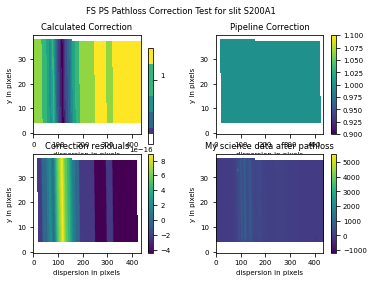

Calculating statistics... 

   Absolute Difference  :   mean = -1.096e-16    median = -2.220e-16    stdev = 3.665e-16
    Maximum   AbsoluteDifference = 8.882e-16
    Minimum   AbsoluteDifference = -4.441e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


Working with slitlet  S200A2
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits


2021-01-22 16:17:27,603 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_fs_ps.py:302: ResourceWarning: unclosed file <_io.FileIO name='/Users/pena/.astropy/cache/download/url/aa0c667e23a747249d9442a76121955c/contents' mode='rb' closefd=True>
  hdul = fits.open(reffile2use)



<Figure size 432x288 with 0 Axes>

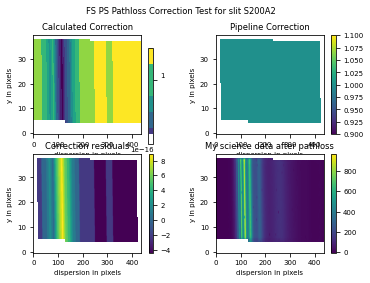

Calculating statistics... 

   Absolute Difference  :   mean = -1.122e-16    median = -2.220e-16    stdev = 3.646e-16
    Maximum   AbsoluteDifference = 8.882e-16
    Minimum   AbsoluteDifference = -4.441e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


Working with slitlet  S400A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Unable to retrieve extension.
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits
Pipeline pathloss correction in datamodel is empty. Skipping testing this slit.

Working with slitlet  S1600A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source 

<Figure size 432x288 with 0 Axes>

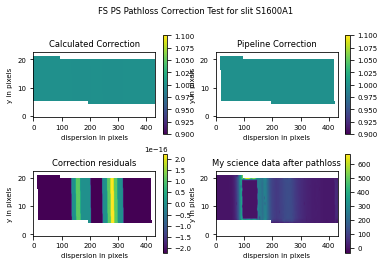

2021-01-22 16:19:19,644 - stpipe - WARNING - <ipython-input-5-e8fd22693926>:63: ResourceWarning: unclosed file <_io.FileIO name='/Users/pena/.astropy/cache/download/url/aa0c667e23a747249d9442a76121955c/contents' mode='rb' closefd=True>
  median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_ps.pathtest(



Calculating statistics... 

   Absolute Difference  :   mean = -1.288e-16    median = -2.220e-16    stdev = 1.365e-16
    Maximum   AbsoluteDifference = 2.220e-16
    Minimum   AbsoluteDifference = -2.220e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


 *** Final pathloss test result reported as PASSED *** 

('* Script FS_PS.py took ', '2.812127999464671 minutes to finish.')
Did pathloss validation test passed?  All slits PASSED path_loss test. 


Testing files for detector:  nrs2


2021-01-22 16:19:29,634 - stpipe - WARNING - /Users/pena/anaconda3/envs/pipedev/lib/python3.8/site-packages/stdatamodels/validate.py:34: ValidationWarning: While validating meta.instrument.fixed_slit the following error occurred:
'FULL' is not one of ['S200A1', 'S200A2', 'S200B1', 'S400A1', 'S1600A1', 'NONE']

Failed validating 'enum' in schema:
    OrderedDict([('title', 'Name of fixed slit aperture used'),
                 ('type', 'string'),
                 ('enum',
                  ['S200A1',
                   'S200A2',
                   'S200B1',
                   'S400A1',
                   'S1600A1',
                   'NONE']),
                 ('fits_keyword', 'FXD_SLIT'),
                 ('blend_table', True)])

On instance:
    'FULL'
  warnings.warn(errmsg, ValidationWarning)



Working with uncal_file:  /Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/pathloss/jwst_pathloss_nirspec_test/fs_prism_nrs2_uncal.fits


2021-01-22 16:19:29,936 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-01-22 16:19:29,937 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-01-22 16:19:29,938 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-01-22 16:19:29,940 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-01-22 16:19:29,942 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-01-22 16:19:29,943 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-01-22 16:19:29,944 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-01-22 16:19:29,946 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-01-22 16:19:29,947 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-01-22 16:19:29,949 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-01-22 1

2021-01-22 16:19:30,259 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2021-01-22 16:19:30,259 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0017.fits'.
2021-01-22 16:19:30,260 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0020.fits'.
2021-01-22 16:19:30,261 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-01-22 16:19:30,262 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-01-22 16:19:30,262 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0021.fits'.
2021-01-22 16:19:30,263 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/Users/pena/crds_cache/references/jwst

2021-01-22 16:19:32,784 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done
2021-01-22 16:19:32,908 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 4, 3200, 2048) from fs_prism_nrs2_uncal.fits>,).
2021-01-22 16:19:32,910 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/pathloss/jwst_pathloss_nirspec_test', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2021-01-22 16:19:32,922 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /Users/pena/crds_cache/refer

2021-01-22 16:20:03,476 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2021-01-22 16:20:03,478 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2021-01-22 16:20:03,494 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-01-22 16:20:03,638 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from fs_prism_nrs2_uncal.fits>,).
2021-01-22 16:20:03,640 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2021-01-22 16:20:03,701 - stpipe.AssignWcsStep - INFO - g

2021-01-22 16:20:10,122 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0001.fits
2021-01-22 16:20:10,196 - stpipe.PathLossStep - INFO - Input exposure type is NRS_FIXEDSLIT
2021-01-22 16:20:10,382 - stpipe.PathLossStep - INFO - Working on slit S200B1
2021-01-22 16:20:10,383 - stpipe.PathLossStep - INFO - Using aperture S200B1
2021-01-22 16:20:10,404 - stpipe.PathLossStep - INFO - Step PathLossStep done
2021-01-22 16:20:10,423 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_fs_ps.py:199: ResourceWarning: unclosed file <_io.FileIO name='/Users/pena/.astropy/cache/download/url/aa0c667e23a747249d9442a76121955c/contents' mode='rb' closefd=True>
  ps_uni_ext_list = get_ps_uni_extensions(reffile, is_point_source)



Running test for FS...
Checking if files exist and obtaining datamodels. This takes a few minutes...
from datamodel  -->     Detector: NRS2   Grating: PRISM   Filter: CLEAR   Lamp: LINE4   EXP_TYPE: NRS_FIXEDSLIT
Now looping through the slits. This may take a while... 
Looping through the wavelengths... 

Working with slitlet  S200B1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits


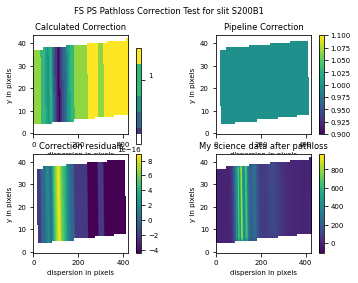

2021-01-22 16:21:04,732 - stpipe - WARNING - <ipython-input-5-e8fd22693926>:63: ResourceWarning: unclosed file <_io.FileIO name='/Users/pena/.astropy/cache/download/url/aa0c667e23a747249d9442a76121955c/contents' mode='rb' closefd=True>
  median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_ps.pathtest(



Calculating statistics... 

   Absolute Difference  :   mean = -1.143e-16    median = -2.220e-16    stdev = 3.639e-16
    Maximum   AbsoluteDifference = 8.882e-16
    Minimum   AbsoluteDifference = -4.441e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


 *** Final pathloss test result reported as PASSED *** 

('* Script FS_PS.py took ', '54.32744598388672 seconds to finish.')
Did pathloss validation test passed?  All slits PASSED path_loss test. 


Testing files for detector:  nrs1
Working with uncal_file:  /Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/pathloss/jwst_pathloss_nirspec_test/fs_fullframe_g35h_f290lp_nrs1_uncal.fits


2021-01-22 16:21:31,264 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-01-22 16:21:31,265 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-01-22 16:21:31,267 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-01-22 16:21:31,268 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-01-22 16:21:31,269 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-01-22 16:21:31,270 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-01-22 16:21:31,271 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-01-22 16:21:31,273 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-01-22 16:21:31,274 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-01-22 16:21:31,275 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-01-22 1

2021-01-22 16:21:31,593 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2021-01-22 16:21:31,593 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0018.fits'.
2021-01-22 16:21:31,594 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0022.fits'.
2021-01-22 16:21:31,594 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-01-22 16:21:31,595 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-01-22 16:21:31,595 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0020.fits'.
2021-01-22 16:21:31,596 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/Users/pena/crds_cache/references/jwst

2021-01-22 16:21:34,863 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done
2021-01-22 16:21:34,970 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 7, 3200, 2048) from fs_fullframe_g35h_f290lp_nrs1_uncal.fits>,).
2021-01-22 16:21:34,972 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/pathloss/jwst_pathloss_nirspec_test', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2021-01-22 16:21:34,986 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /Users/pena/

2021-01-22 16:22:38,408 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from fs_fullframe_g35h_f290lp_nrs1_uncal.fits>,).
2021-01-22 16:22:38,410 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/pathloss/jwst_pathloss_nirspec_test'}
2021-01-22 16:22:38,464 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-01-22 16:22:38,465 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2021-01-22 16:22:38,467 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2

2021-01-22 16:22:42,348 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.187720636 -45.680802803 156.187307671 -45.680405209 156.186792650 -45.680671077 156.187205560 -45.681068709
2021-01-22 16:22:42,349 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.187720636 -45.680802803 156.187307671 -45.680405209 156.186792650 -45.680671077 156.187205560 -45.681068709
2021-01-22 16:22:42,468 - stpipe.Extract2dStep - INFO - Step Extract2dStep done
2021-01-22 16:22:42,492 - stpipe.SourceTypeStep - INFO - SourceTypeStep instance created.
2021-01-22 16:22:42,584 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep running with args (<MultiSlitModel from fs_fullframe_g35h_f290lp_nrs1_uncal.fits>,).
2021-01-22 16:22:42,585 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': Fal

Running test for FS...
Checking if files exist and obtaining datamodels. This takes a few minutes...
from datamodel  -->     Detector: NRS1   Grating: G395H   Filter: F290LP   Lamp: LINE3   EXP_TYPE: NRS_FIXEDSLIT
Now looping through the slits. This may take a while... 
Looping through the wavelengths... 

Working with slitlet  S200A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits


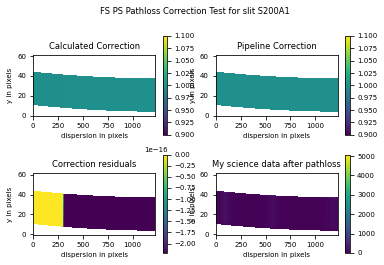

Calculating statistics... 

   Absolute Difference  :   mean = -1.668e-16    median = -2.220e-16    stdev = 9.602e-17
    Maximum   AbsoluteDifference = 0.000e+00
    Minimum   AbsoluteDifference = -2.220e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


Working with slitlet  S200A2
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits


2021-01-22 16:24:21,284 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_fs_ps.py:302: ResourceWarning: unclosed file <_io.FileIO name='/Users/pena/.astropy/cache/download/url/aa0c667e23a747249d9442a76121955c/contents' mode='rb' closefd=True>
  hdul = fits.open(reffile2use)



<Figure size 432x288 with 0 Axes>

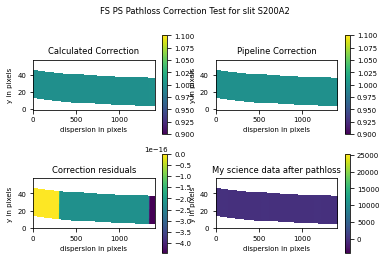

Calculating statistics... 

   Absolute Difference  :   mean = -1.848e-16    median = -2.220e-16    stdev = 1.074e-16
    Maximum   AbsoluteDifference = 0.000e+00
    Minimum   AbsoluteDifference = -4.441e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


Working with slitlet  S400A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Unable to retrieve extension.
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits
Pipeline pathloss correction in datamodel is empty. Skipping testing this slit.

Working with slitlet  S1600A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source 

<Figure size 432x288 with 0 Axes>

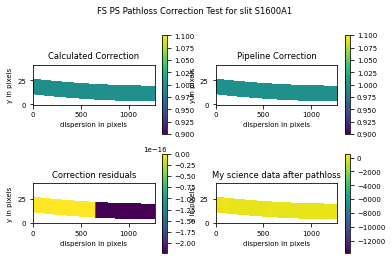

2021-01-22 16:26:12,965 - stpipe - WARNING - <ipython-input-5-e8fd22693926>:63: ResourceWarning: unclosed file <_io.FileIO name='/Users/pena/.astropy/cache/download/url/aa0c667e23a747249d9442a76121955c/contents' mode='rb' closefd=True>
  median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_ps.pathtest(



Calculating statistics... 

   Absolute Difference  :   mean = -1.084e-16    median = 0.000e+00    stdev = 1.110e-16
    Maximum   AbsoluteDifference = 0.000e+00
    Minimum   AbsoluteDifference = -2.220e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


 *** Final pathloss test result reported as PASSED *** 

('* Script FS_PS.py took ', '2.7152812123298644 minutes to finish.')
Did pathloss validation test passed?  All slits PASSED path_loss test. 


Testing files for detector:  nrs2
Working with uncal_file:  /Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/pathloss/jwst_pathloss_nirspec_test/fs_fullframe_g35h_f290lp_nrs2_uncal.fits


2021-01-22 16:26:33,538 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-01-22 16:26:33,540 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-01-22 16:26:33,541 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-01-22 16:26:33,543 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-01-22 16:26:33,545 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-01-22 16:26:33,546 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-01-22 16:26:33,548 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-01-22 16:26:33,549 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-01-22 16:26:33,551 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-01-22 16:26:33,553 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-01-22 1

2021-01-22 16:26:33,898 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2021-01-22 16:26:33,898 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0017.fits'.
2021-01-22 16:26:33,899 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0020.fits'.
2021-01-22 16:26:33,900 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-01-22 16:26:33,900 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-01-22 16:26:33,901 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0021.fits'.
2021-01-22 16:26:33,902 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/Users/pena/crds_cache/references/jwst

2021-01-22 16:26:40,372 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done
2021-01-22 16:26:40,547 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 7, 3200, 2048) from fs_fullframe_g35h_f290lp_nrs2_uncal.fits>,).
2021-01-22 16:26:40,549 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/pathloss/jwst_pathloss_nirspec_test', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2021-01-22 16:26:40,563 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /Users/pena/

2021-01-22 16:27:41,997 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 2048, 2048) from fs_fullframe_g35h_f290lp_nrs2_uncal.fits>,).
2021-01-22 16:27:41,998 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': '/Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/pathloss/jwst_pathloss_nirspec_test'}
2021-01-22 16:27:42,052 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file
2021-01-22 16:27:42,053 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped
2021-01-22 16:27:42,055 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done
2

2021-01-22 16:27:45,647 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.187720636 -45.680802803 156.187307671 -45.680405209 156.186792650 -45.680671077 156.187205560 -45.681068709
2021-01-22 16:27:45,839 - stpipe.Extract2dStep - INFO - Name of subarray extracted: S200B1
2021-01-22 16:27:45,840 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 140 2048
2021-01-22 16:27:45,840 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 925 1037
2021-01-22 16:27:46,145 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-01-22 16:27:46,155 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.238745821 -45.653926065 156.237887188 -45.653118339 156.237822146 -45.653151380 156.238680762 -45.653959111
2021-01-22 16:27:46,156 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.238745821 -45.653926065 156.237887188 -45.653118339 156.237822146 -45.653151380 156.238680762 -45.653959111
2021-01-22 16:27:46,339 - stpipe.Extract

Running test for FS...
Checking if files exist and obtaining datamodels. This takes a few minutes...
from datamodel  -->     Detector: NRS2   Grating: G395H   Filter: F290LP   Lamp: LINE3   EXP_TYPE: NRS_FIXEDSLIT
Now looping through the slits. This may take a while... 
Looping through the wavelengths... 

Working with slitlet  S200A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits


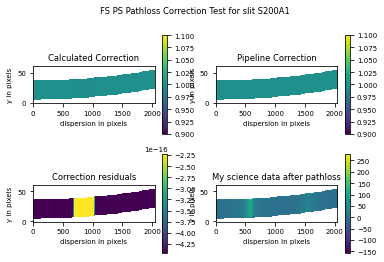

Calculating statistics... 

   Absolute Difference  :   mean = -4.059e-16    median = -4.441e-16    stdev = 8.382e-17
    Maximum   AbsoluteDifference = -2.220e-16
    Minimum   AbsoluteDifference = -4.441e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


Working with slitlet  S200A2
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension


2021-01-22 16:30:17,371 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_fs_ps.py:302: ResourceWarning: unclosed file <_io.FileIO name='/Users/pena/.astropy/cache/download/url/aa0c667e23a747249d9442a76121955c/contents' mode='rb' closefd=True>
  hdul = fits.open(reffile2use)



Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits


<Figure size 432x288 with 0 Axes>

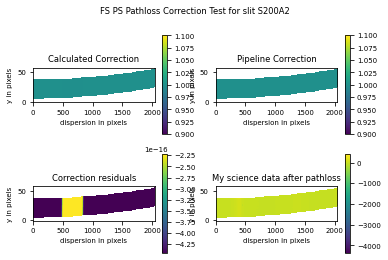

Calculating statistics... 

   Absolute Difference  :   mean = -4.060e-16    median = -4.441e-16    stdev = 8.374e-17
    Maximum   AbsoluteDifference = -2.220e-16
    Minimum   AbsoluteDifference = -4.441e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


Working with slitlet  S400A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Unable to retrieve extension.
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits
Pipeline pathloss correction in datamodel is empty. Skipping testing this slit.

Working with slitlet  S1600A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source

<Figure size 432x288 with 0 Axes>

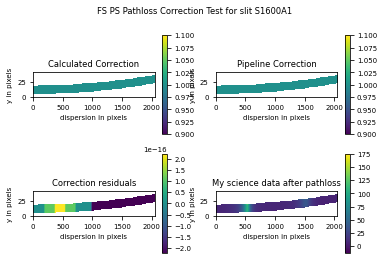

Calculating statistics... 

   Absolute Difference  :   mean = -7.765e-17    median = -2.220e-16    stdev = 1.613e-16
    Maximum   AbsoluteDifference = 2.220e-16
    Minimum   AbsoluteDifference = -2.220e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


Working with slitlet  S200B1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits


<Figure size 432x288 with 0 Axes>

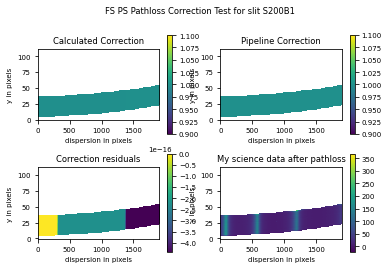

2021-01-22 16:33:00,269 - stpipe - WARNING - <ipython-input-5-e8fd22693926>:63: ResourceWarning: unclosed file <_io.FileIO name='/Users/pena/.astropy/cache/download/url/aa0c667e23a747249d9442a76121955c/contents' mode='rb' closefd=True>
  median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_ps.pathtest(



Calculating statistics... 

   Absolute Difference  :   mean = -2.490e-16    median = -2.220e-16    stdev = 1.455e-16
    Maximum   AbsoluteDifference = 0.000e+00
    Minimum   AbsoluteDifference = -4.441e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


 *** Final pathloss test result reported as PASSED *** 

('* Script FS_PS.py took ', '3.6495805184046426 minutes to finish.')
Did pathloss validation test passed?  All slits PASSED path_loss test. 


Testing files for detector:  nrs1
Working with uncal_file:  /Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/pathloss/jwst_pathloss_nirspec_test/fs_allslits_g140h_f100lp_nrs1_uncal.fits


2021-01-22 16:33:47,759 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-01-22 16:33:47,760 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-01-22 16:33:47,761 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-01-22 16:33:47,763 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-01-22 16:33:47,764 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-01-22 16:33:47,766 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-01-22 16:33:47,768 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-01-22 16:33:47,769 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-01-22 16:33:47,771 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-01-22 16:33:47,772 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-01-22 1

2021-01-22 16:33:48,326 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2021-01-22 16:33:48,327 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0006.fits'.
2021-01-22 16:33:48,327 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-01-22 16:33:48,328 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-01-22 16:33:48,329 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-01-22 16:33:48,329 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0010.fits'.
2021-01-22 16:33:48,330 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0109.fits'.
2021-01-22 16:33:48,331 - stp

2021-01-22 16:33:55,636 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0008.fits
2021-01-22 16:33:56,415 - stpipe.Detector1Pipeline.linearity - INFO - Extracting linearity subarray to match science data
2021-01-22 16:33:57,072 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-01-22 16:33:57,241 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs1_uncal.fits>,).
2021-01-22 16:33:57,242 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/pena/Documents/NIRSpec_projects/pipeline_testing_noteb

2021-01-22 16:39:10,339 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 491393 pixels with at least one CR
2021-01-22 16:39:36,303 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 23:
2021-01-22 16:39:36,480 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 358033 pixels with at least one CR
2021-01-22 16:40:01,006 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 24:
2021-01-22 16:40:01,171 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 439026 pixels with at least one CR
2021-01-22 16:40:22,171 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 25:
2021-01-22 16:40:22,347 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 63409 pixels with at least one CR
2021-01-22 16:40:24,758 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 385.782 sec
2021-01-22 16:40:24,765 - stpipe.Detector1Pipeline.jump - INFO - The execution 

2021-01-22 16:44:19,500 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/pena/anaconda3/envs/pipedev/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:864: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int,:,:,:] *= ( segs_4[num_int,:,:,:] > 0)

2021-01-22 16:44:21,079 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/pena/anaconda3/envs/pipedev/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:864: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int,:,:,:] *= ( segs_4[num_int,:,:,:] > 0)

2021-01-22 16:44:22,276 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/pena/anaconda3/envs/pipedev/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:864: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int,:,:,:] *= ( segs_4[num_int,:,:,:] > 0)

2021-01-22 16:44:23,394 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/pena/anaconda3/envs/pipedev/lib/python3.8/site-packages/jwst/ramp_fitting/ramp

2021-01-22 16:44:27,872 - stpipe.Extract2dStep - INFO - EXP_TYPE is NRS_FIXEDSLIT
2021-01-22 16:44:28,020 - stpipe.Extract2dStep - INFO - Name of subarray extracted: S200A1
2021-01-22 16:44:28,021 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1921
2021-01-22 16:44:28,021 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 159 227
2021-01-22 16:44:28,140 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-01-22 16:44:28,298 - stpipe.Extract2dStep - INFO - Name of subarray extracted: S200A2
2021-01-22 16:44:28,298 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1729
2021-01-22 16:44:28,299 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 123 194
2021-01-22 16:44:28,433 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-01-22 16:44:28,563 - stpipe.Extract2dStep - INFO - Name of subarray extracted: S400A1
2021-01-22 16:44:28,563 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 0 1848
2021-01-22 16:44:28,564 - stpipe.Ext

Running test for FS...
Checking if files exist and obtaining datamodels. This takes a few minutes...
from datamodel  -->     Detector: NRS1   Grating: G140H   Filter: OPAQUE   Lamp: NO_LAMP   EXP_TYPE: NRS_FIXEDSLIT
Now looping through the slits. This may take a while... 
Looping through the wavelengths... 

Working with slitlet  S200A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits


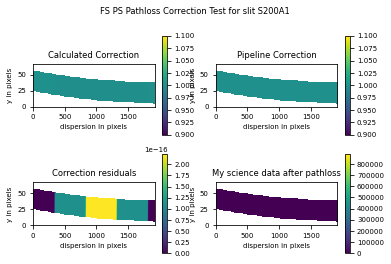

2021-01-22 16:46:05,904 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_fs_ps.py:302: ResourceWarning: unclosed file <_io.FileIO name='/Users/pena/.astropy/cache/download/url/aa0c667e23a747249d9442a76121955c/contents' mode='rb' closefd=True>
  hdul = fits.open(reffile2use)



Calculating statistics... 

   Absolute Difference  :   mean = 1.131e-16    median = 1.110e-16    stdev = 7.775e-17
    Maximum   AbsoluteDifference = 2.220e-16
    Minimum   AbsoluteDifference = 0.000e+00
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


Working with slitlet  S200A2
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits


<Figure size 432x288 with 0 Axes>

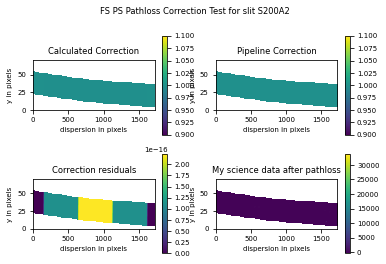

Calculating statistics... 

   Absolute Difference  :   mean = 1.256e-16    median = 1.110e-16    stdev = 7.169e-17
    Maximum   AbsoluteDifference = 2.220e-16
    Minimum   AbsoluteDifference = 0.000e+00
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


Working with slitlet  S400A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Unable to retrieve extension.
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits
Pipeline pathloss correction in datamodel is empty. Skipping testing this slit.

Working with slitlet  S1600A1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source ext

<Figure size 432x288 with 0 Axes>

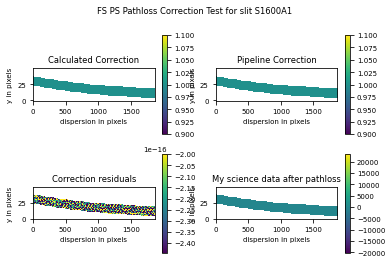

Calculating statistics... 

   Absolute Difference  :   mean = -2.220e-16    median = -2.220e-16    stdev = 0.000e+00
    Maximum   AbsoluteDifference = -2.220e-16
    Minimum   AbsoluteDifference = -2.220e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


Working with slitlet  S200B1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits


<Figure size 432x288 with 0 Axes>

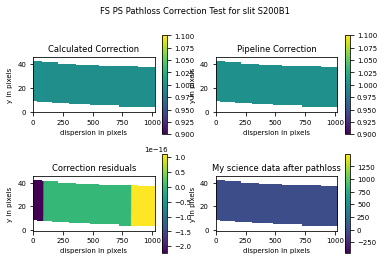

2021-01-22 16:48:35,758 - stpipe - WARNING - <ipython-input-5-e8fd22693926>:63: ResourceWarning: unclosed file <_io.FileIO name='/Users/pena/.astropy/cache/download/url/aa0c667e23a747249d9442a76121955c/contents' mode='rb' closefd=True>
  median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_ps.pathtest(



Calculating statistics... 

   Absolute Difference  :   mean = 2.768e-18    median = 0.000e+00    stdev = 8.117e-17
    Maximum   AbsoluteDifference = 1.110e-16
    Minimum   AbsoluteDifference = -2.220e-16
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


 *** Final pathloss test result reported as PASSED *** 

('* Script FS_PS.py took ', '3.325615382194519 minutes to finish.')
Did pathloss validation test passed?  All slits PASSED path_loss test. 


Testing files for detector:  nrs2
Working with uncal_file:  /Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/pathloss/jwst_pathloss_nirspec_test/fs_allslits_g140h_f100lp_nrs2_uncal.fits


2021-01-22 16:49:16,306 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-01-22 16:49:16,307 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-01-22 16:49:16,308 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-01-22 16:49:16,310 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-01-22 16:49:16,311 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-01-22 16:49:16,313 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-01-22 16:49:16,314 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-01-22 16:49:16,315 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-01-22 16:49:16,317 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-01-22 16:49:16,319 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-01-22 1

2021-01-22 16:49:16,823 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2021-01-22 16:49:16,823 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0007.fits'.
2021-01-22 16:49:16,824 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-01-22 16:49:16,825 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-01-22 16:49:16,825 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-01-22 16:49:16,826 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0011.fits'.
2021-01-22 16:49:16,827 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0148.fits'.
2021-01-22 16:49:16,828 - stp

2021-01-22 16:49:23,958 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0009.fits
2021-01-22 16:49:24,700 - stpipe.Detector1Pipeline.linearity - INFO - Extracting linearity subarray to match science data
2021-01-22 16:49:25,338 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-01-22 16:49:25,489 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(25, 10, 256, 2048) from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).
2021-01-22 16:49:25,491 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/pena/Documents/NIRSpec_projects/pipeline_testing_noteb

2021-01-22 16:52:50,560 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 145703 pixels with at least one CR
2021-01-22 16:52:55,169 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 23:
2021-01-22 16:52:55,330 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 397928 pixels with at least one CR
2021-01-22 16:53:10,350 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 24:
2021-01-22 16:53:10,522 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 116251 pixels with at least one CR
2021-01-22 16:53:14,556 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 25:
2021-01-22 16:53:14,738 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier Two-point found 265529 pixels with at least one CR
2021-01-22 16:53:24,892 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 237.777 sec
2021-01-22 16:53:24,897 - stpipe.Detector1Pipeline.jump - INFO - The execution

2021-01-22 16:56:41,657 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/pena/anaconda3/envs/pipedev/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:864: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int,:,:,:] *= ( segs_4[num_int,:,:,:] > 0)

2021-01-22 16:56:42,631 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/pena/anaconda3/envs/pipedev/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:864: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int,:,:,:] *= ( segs_4[num_int,:,:,:] > 0)

2021-01-22 16:56:43,733 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/pena/anaconda3/envs/pipedev/lib/python3.8/site-packages/jwst/ramp_fitting/ramp_fit.py:864: RuntimeWarning: invalid value encountered in multiply
  var_p4[num_int,:,:,:] *= ( segs_4[num_int,:,:,:] > 0)

2021-01-22 16:56:44,827 - stpipe.Detector1Pipeline.ramp_fit - WARNING - /Users/pena/anaconda3/envs/pipedev/lib/python3.8/site-packages/jwst/ramp_fitting/ramp

2021-01-22 16:56:49,229 - stpipe.Extract2dStep - INFO - Extract2dStep instance created.
2021-01-22 16:56:49,324 - stpipe.Extract2dStep - INFO - Step Extract2dStep running with args (<ImageModel(256, 2048) from fs_allslits_g140h_f100lp_nrs2_uncal.fits>,).
2021-01-22 16:56:49,326 - stpipe.Extract2dStep - INFO - Step Extract2dStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'slit_name': None, 'extract_orders': None, 'tsgrism_extract_height': None, 'wfss_extract_half_height': 5, 'grism_objects': None, 'mmag_extract': 99.0}
2021-01-22 16:56:49,339 - stpipe.Extract2dStep - INFO - EXP_TYPE is NRS_FIXEDSLIT
2021-01-22 16:56:49,442 - stpipe.Extract2dStep - INFO - Name of subarray extracted: S200B1
2021-01-22 16:56:49,443 - stpipe.Extract2dStep - INFO - Subarray x-extents are

Running test for FS...
Checking if files exist and obtaining datamodels. This takes a few minutes...
from datamodel  -->     Detector: NRS2   Grating: G140H   Filter: OPAQUE   Lamp: NO_LAMP   EXP_TYPE: NRS_FIXEDSLIT
Now looping through the slits. This may take a while... 
Looping through the wavelengths... 

Working with slitlet  S200B1
Slitlet name in fits file previous to pathloss
            and in pathloss output file are the same.
            
Retrieved point source extension
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0001.fits


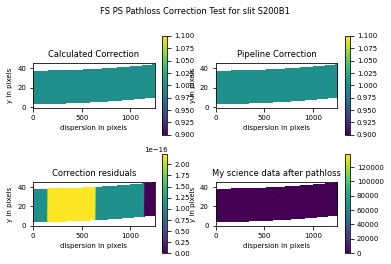

2021-01-22 16:57:45,488 - stpipe - WARNING - <ipython-input-5-e8fd22693926>:63: ResourceWarning: unclosed file <_io.FileIO name='/Users/pena/.astropy/cache/download/url/aa0c667e23a747249d9442a76121955c/contents' mode='rb' closefd=True>
  median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_ps.pathtest(



Calculating statistics... 

   Absolute Difference  :   mean = 1.451e-16    median = 1.110e-16    stdev = 6.952e-17
    Maximum   AbsoluteDifference = 2.220e-16
    Minimum   AbsoluteDifference = 0.000e+00
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 0%
                            ->  3xtheshold = 0%
                            ->  5xtheshold = 0%
 *** Result of the test: PASSED


 *** Final pathloss test result reported as PASSED *** 

('* Script FS_PS.py took ', '49.17950224876404 seconds to finish.')
Did pathloss validation test passed?  All slits PASSED path_loss test. 


Testing files for detector:  nrs1
Working with uncal_file:  /Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/pathloss/jwst_pathloss_nirspec_test/mos_prism_nrs1_uncal.fits


2021-01-22 16:57:54,419 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-01-22 16:57:54,421 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-01-22 16:57:54,423 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-01-22 16:57:54,425 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-01-22 16:57:54,427 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-01-22 16:57:54,428 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-01-22 16:57:54,430 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-01-22 16:57:54,432 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-01-22 16:57:54,434 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-01-22 16:57:54,436 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-01-22 1

2021-01-22 16:57:54,699 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2021-01-22 16:57:54,700 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0018.fits'.
2021-01-22 16:57:54,700 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0022.fits'.
2021-01-22 16:57:54,701 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-01-22 16:57:54,702 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-01-22 16:57:54,702 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0020.fits'.
2021-01-22 16:57:54,703 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/Users/pena/crds_cache/references/jwst

2021-01-22 16:57:56,975 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done
2021-01-22 16:57:57,068 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs1_uncal.fits>,).
2021-01-22 16:57:57,070 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/pathloss/jwst_pathloss_nirspec_test', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2021-01-22 16:57:57,082 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /Users/pena/crds_cache/refe

2021-01-22 16:58:25,491 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2021-01-22 16:58:25,491 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2021-01-22 16:58:25,506 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-01-22 16:58:25,625 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from mos_prism_nrs1_uncal.fits>,).
2021-01-22 16:58:25,627 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2021-01-22 16:58:25,671 - stpipe.AssignWcsStep - INFO - 

N/A


2021-01-22 16:58:26,095 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS1: [3, 4]
2021-01-22 16:58:26,096 - stpipe.AssignWcsStep - INFO - Computing WCS for 2 open slitlets
2021-01-22 16:58:26,116 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg
2021-01-22 16:58:26,116 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg
2021-01-22 16:58:26,117 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg
2021-01-22 16:58:26,118 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg
2021-01-22 16:58:26,138 - stpipe.AssignWcsStep - INFO - SPORDER= 0, wrange=[6e-07, 5.3e-06]
2021-01-22 16:58:26,302 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 1
2021-01-22 16:58:26,302 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 2
2021-01-22 16:58:26,303 - stpipe.AssignWcsStep - INFO - There are 1 open slits in quadrant 3
2021-01-22 16:58:26,317 - stpipe.AssignWcsStep - INFO - There are 1 op

2021-01-22 16:58:46,019 - stpipe.FlatFieldStep - INFO - Working on slit 3
2021-01-22 16:58:46,618 - stpipe.FlatFieldStep - INFO - Working on slit 4
2021-01-22 16:58:47,208 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done
2021-01-22 16:58:47,225 - stpipe.PathLossStep - INFO - PathLossStep instance created.
2021-01-22 16:58:47,433 - stpipe.PathLossStep - INFO - Step PathLossStep running with args (<MultiSlitModel from mos_prism_nrs1_uncal.fits>,).
2021-01-22 16:58:47,434 - stpipe.PathLossStep - INFO - Step PathLossStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}
2021-01-22 16:58:47,451 - stpipe.PathLossStep - INFO - Using PATHLOSS reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0002.fits

Running test for MOS...
Checking if files exist and obtaining datamodels. This takes a few minutes...
from datamodel  -->     Detector: NRS1   Grating: PRISM   Filter: CLEAR   Lamp: LINE4   EXP_TYPE: NRS_MSASPEC
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0002.fits
Retrieving exensions
Looping through the slits... 
Retrieved point source extension 1
Working with slitlet  3
Slitlet name in fits file previous to pathloss
                   and in pathloss output file are the same.


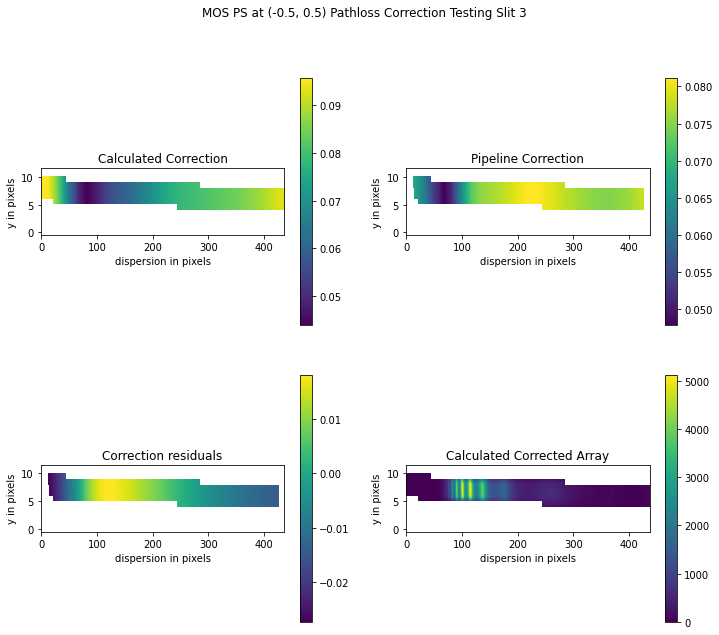

2021-01-22 17:06:28,221 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_mos_ps.py:254: ResourceWarning: unclosed file <_io.FileIO name='/Users/pena/.astropy/cache/download/url/8e6d6917d5834a76434dc30e12182a4d/contents' mode='rb' closefd=True>
  hdul = fits.open(reffile)



Calculating statistics... 

   Absolute Difference  :   mean = -5.929e-04    median = -1.431e-03    stdev = 1.196e-02
    Maximum   AbsoluteDifference = 1.808e-02
    Minimum   AbsoluteDifference = -2.730e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 99%
                            ->  3xtheshold = 99%
                            ->  5xtheshold = 97%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  4
Slitlet name in fits file previous to pathloss
                   and in pathloss output file are the same.


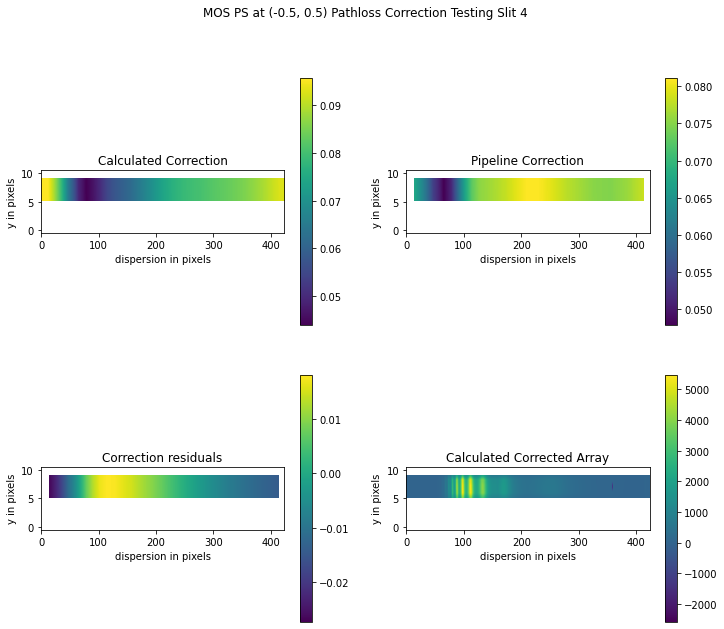

2021-01-22 17:13:56,257 - stpipe - WARNING - <ipython-input-5-e8fd22693926>:84: ResourceWarning: unclosed file <_io.FileIO name='/Users/pena/.astropy/cache/download/url/8e6d6917d5834a76434dc30e12182a4d/contents' mode='rb' closefd=True>
  median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_mos_ps.pathtest(



Calculating statistics... 

   Absolute Difference  :   mean = -3.733e-04    median = -1.415e-03    stdev = 1.197e-02
    Maximum   AbsoluteDifference = 1.808e-02
    Minimum   AbsoluteDifference = -2.730e-02
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 100%
                            ->  3xtheshold = 99%
                            ->  5xtheshold = 98%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 *** Result of the test: FAILED


 *** Final pathloss test result reported as FAILED *** 

('* Script MSA.py took ', '15.140620680650075 minutes to finish.')
Did pathloss validation test passed?  One or more slits FAILED path_loss test. 


Testing files for detector:  nrs2
Working with uncal_file:  /Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks

2021-01-22 17:14:06,506 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-01-22 17:14:06,508 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-01-22 17:14:06,509 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-01-22 17:14:06,510 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-01-22 17:14:06,511 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-01-22 17:14:06,513 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-01-22 17:14:06,514 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-01-22 17:14:06,516 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-01-22 17:14:06,518 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-01-22 17:14:06,520 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-01-22 1

2021-01-22 17:14:06,740 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2021-01-22 17:14:06,740 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0017.fits'.
2021-01-22 17:14:06,741 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0020.fits'.
2021-01-22 17:14:06,742 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-01-22 17:14:06,742 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-01-22 17:14:06,743 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0021.fits'.
2021-01-22 17:14:06,743 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/Users/pena/crds_cache/references/jwst

2021-01-22 17:14:09,137 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done
2021-01-22 17:14:09,251 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 4, 3200, 2048) from mos_prism_nrs2_uncal.fits>,).
2021-01-22 17:14:09,253 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/pathloss/jwst_pathloss_nirspec_test', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}
2021-01-22 17:14:09,266 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /Users/pena/crds_cache/refe

2021-01-22 17:14:37,395 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1
2021-01-22 17:14:37,396 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done
2021-01-22 17:14:37,411 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2021-01-22 17:14:37,553 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from mos_prism_nrs2_uncal.fits>,).
2021-01-22 17:14:37,555 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}
2021-01-22 17:14:37,604 - stpipe.AssignWcsStep - INFO - 

N/A


2021-01-22 17:14:37,630 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.0332140289247036 deg
2021-01-22 17:14:37,631 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3367482721805573 deg
2021-01-22 17:14:37,632 - stpipe.AssignWcsStep - INFO - theta_y correction: -1.0907214098475986e-05 deg
2021-01-22 17:14:37,633 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg
2021-01-22 17:14:37,987 - stpipe.AssignWcsStep - INFO - Removing slit 3 from the list of open slits because the WCS bounding_box is completely outside the detector.
2021-01-22 17:14:38,049 - stpipe.AssignWcsStep - INFO - Removing slit 4 from the list of open slits because the WCS bounding_box is completely outside the detector.
2021-01-22 17:14:38,050 - stpipe.AssignWcsStep - INFO - Slits projected on detector NRS2: []
2021-01-22 17:14:38,050 - stpipe.AssignWcsStep - CRITICAL - No open slits fall on detector NRS2.


An error occurred that made the pipeline crash, probably: No open slits fall on detector  nrs2
Continuing with the next data set in the test. 

Testing files for detector:  nrs1
Working with uncal_file:  /Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/pathloss/jwst_pathloss_nirspec_test/mos_g140m_line1_NRS1_uncal.fits


2021-01-22 17:14:45,978 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.
2021-01-22 17:14:45,979 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.
2021-01-22 17:14:45,980 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.
2021-01-22 17:14:45,982 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.
2021-01-22 17:14:45,983 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.
2021-01-22 17:14:45,985 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.
2021-01-22 17:14:45,986 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.
2021-01-22 17:14:45,987 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.
2021-01-22 17:14:45,989 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.
2021-01-22 17:14:45,992 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.
2021-01-22 1

2021-01-22 17:14:46,227 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.
2021-01-22 17:14:46,227 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0019.fits'.
2021-01-22 17:14:46,228 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is 'N/A'.
2021-01-22 17:14:46,228 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.
2021-01-22 17:14:46,229 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.
2021-01-22 17:14:46,229 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0023.fits'.
2021-01-22 17:14:46,230 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0087.fits'.
2021-01-22 17:14:46,230 - stp

2021-01-22 17:14:50,826 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0019.fits
2021-01-22 17:14:51,501 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done
2021-01-22 17:14:51,603 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 6, 2048, 2048) from mos_g140m_line1_NRS1_uncal.fits>,).
2021-01-22 17:14:51,604 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '/Users/pena/Documents/NIRSpec_projects/pipeline_testing_notebooks/jwst_validation_notebooks/jwst_validation_notebooks/pathloss/jwst_pathloss_nirspec_test', 'dark_output': None}
2021-01-22 17:14

V8460001000101_msa.fits


2021-01-22 17:15:19,357 - stpipe.AssignWcsStep - INFO - Retrieving open MSA slitlets for msa_metadata_id = 1 and dither_index = 1
2021-01-22 17:15:19,597 - stpipe.AssignWcsStep - INFO - gwa_ytilt is 0.1260581910610199 deg
2021-01-22 17:15:19,598 - stpipe.AssignWcsStep - INFO - gwa_xtilt is 0.3316612243652344 deg
2021-01-22 17:15:19,599 - stpipe.AssignWcsStep - INFO - theta_y correction: 0.0002496099796717191 deg
2021-01-22 17:15:19,600 - stpipe.AssignWcsStep - INFO - theta_x correction: 0.0 deg
2021-01-22 17:15:19,856 - stpipe.AssignWcsStep - INFO - Removing slit 6 from the list of open slits because the WCS bounding_box is completely outside the detector.
2021-01-22 17:15:19,874 - stpipe.AssignWcsStep - INFO - Removing slit 7 from the list of open slits because the WCS bounding_box is completely outside the detector.
2021-01-22 17:15:19,893 - stpipe.AssignWcsStep - INFO - Removing slit 8 from the list of open slits because the WCS bounding_box is completely outside the detector.
2021-

2021-01-22 17:15:21,456 - stpipe.AssignWcsStep - INFO - There are 4 open slits in quadrant 3
2021-01-22 17:15:21,496 - stpipe.AssignWcsStep - INFO - There are 10 open slits in quadrant 4
2021-01-22 17:15:21,592 - stpipe.AssignWcsStep - INFO - There are 0 open slits in quadrant 5
2021-01-22 17:15:21,933 - stpipe.AssignWcsStep - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0004.asdf', 'camera': '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0004.asdf', 'collimator': '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0004.asdf', 'disperser': '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0032.asdf', 'fore': '/Users/pena/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0023.asdf', 'fpa': '/Users/pena/crds_cache/references/jwst/nirspec

2021-01-22 17:15:38,960 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.219673020 -45.648613077 156.219545303 -45.648492383 156.219483265 -45.648524021 156.219610979 -45.648644716
2021-01-22 17:15:38,961 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.219673020 -45.648613077 156.219545303 -45.648492383 156.219483265 -45.648524021 156.219610979 -45.648644716
2021-01-22 17:15:39,446 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 46
2021-01-22 17:15:39,447 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 1882 2048
2021-01-22 17:15:39,447 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 202 218
2021-01-22 17:15:39,724 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-01-22 17:15:39,731 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.211127421 -45.641279813 156.211000463 -45.641159678 156.210938572 -45.641191268 156.211065527 -45.641311404
2021-01-22 17:15:39,732 - stpipe.Extract2dSte

2021-01-22 17:15:46,798 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-01-22 17:15:46,809 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.191192483 -45.697686513 156.191064493 -45.697562756 156.191002259 -45.697595026 156.191130247 -45.697718784
2021-01-22 17:15:46,810 - stpipe.Extract2dStep - INFO - Updated S_REGION to POLYGON ICRS  156.191192483 -45.697686513 156.191064493 -45.697562756 156.191002259 -45.697595026 156.191130247 -45.697718784
2021-01-22 17:15:47,288 - stpipe.Extract2dStep - INFO - Name of subarray extracted: 56
2021-01-22 17:15:47,289 - stpipe.Extract2dStep - INFO - Subarray x-extents are: 872 2048
2021-01-22 17:15:47,289 - stpipe.Extract2dStep - INFO - Subarray y-extents are: 768 783
2021-01-22 17:15:47,407 - stpipe.Extract2dStep - INFO - set slit_attributes completed
2021-01-22 17:15:47,415 - stpipe.Extract2dStep - INFO - Update S_REGION to POLYGON ICRS  156.191122501 -45.671742959 156.190995485 -45.671621176 156.190933579 -4

2021-01-22 17:15:57,833 - stpipe.SourceTypeStep - INFO - Step SourceTypeStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}
2021-01-22 17:15:57,845 - stpipe.SourceTypeStep - INFO - Input EXP_TYPE is NRS_MSASPEC
2021-01-22 17:15:57,846 - stpipe.SourceTypeStep - INFO - source_id=53, stellarity=0.0000, type=EXTENDED
2021-01-22 17:15:57,847 - stpipe.SourceTypeStep - INFO - source_id=54, stellarity=0.0000, type=EXTENDED
2021-01-22 17:15:57,847 - stpipe.SourceTypeStep - INFO - source_id=42, stellarity=0.0000, type=EXTENDED
2021-01-22 17:15:57,848 - stpipe.SourceTypeStep - INFO - source_id=43, stellarity=0.0000, type=EXTENDED
2021-01-22 17:15:57,849 - stpipe.SourceTypeStep - INFO - source_id=44, stellarity=0.0000, type=EXTENDED
2021-01-22 17:15:57,850 - stpipe.SourceTypeStep 

2021-01-22 17:16:43,276 - stpipe.PathLossStep - INFO - Working on slit 17
2021-01-22 17:16:43,292 - stpipe.PathLossStep - INFO - Working on slit 18
2021-01-22 17:16:43,308 - stpipe.PathLossStep - INFO - Working on slit 19
2021-01-22 17:16:43,323 - stpipe.PathLossStep - INFO - Working on slit 20
2021-01-22 17:16:43,339 - stpipe.PathLossStep - INFO - Working on slit 21
2021-01-22 17:16:43,356 - stpipe.PathLossStep - INFO - Working on slit 22
2021-01-22 17:16:43,372 - stpipe.PathLossStep - INFO - Working on slit 23
2021-01-22 17:16:43,388 - stpipe.PathLossStep - INFO - Working on slit 24
2021-01-22 17:16:43,403 - stpipe.PathLossStep - INFO - Working on slit 25
2021-01-22 17:16:43,420 - stpipe.PathLossStep - INFO - Working on slit 26
2021-01-22 17:16:43,437 - stpipe.PathLossStep - INFO - Step PathLossStep done
2021-01-22 17:16:43,452 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_

Running test for MOS...
Checking if files exist and obtaining datamodels. This takes a few minutes...
from datamodel  -->     Detector: NRS1   Grating: G140M   Filter: F100LP   Lamp: LINE1   EXP_TYPE: NRS_MSASPEC
Using reference file: https://jwst-crds.stsci.edu/unchecked_get/references/jwst/jwst_nirspec_pathloss_0002.fits
Retrieving exensions
Looping through the slits... 
Retrieved point source extension 1
Working with slitlet  53
Slitlet name in fits file previous to pathloss
                   and in pathloss output file are the same.


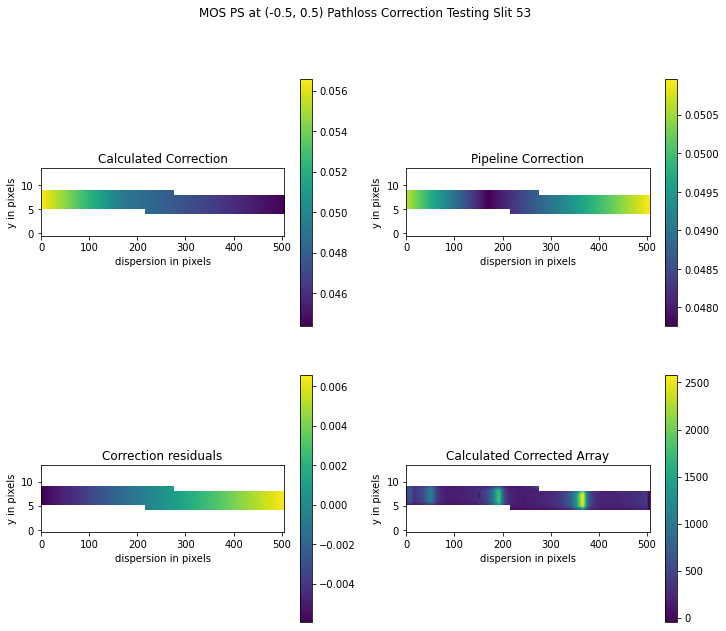

2021-01-22 17:24:41,628 - stpipe - WARNING - /Users/pena/Documents/NIRSpec_projects/nirspec_pipe_testing_tool/nirspec_pipe_testing_tool/calwebb_spec2_pytests/auxiliary_code/pathloss_mos_ps.py:254: ResourceWarning: unclosed file <_io.FileIO name='/Users/pena/.astropy/cache/download/url/8e6d6917d5834a76434dc30e12182a4d/contents' mode='rb' closefd=True>
  hdul = fits.open(reffile)



Calculating statistics... 

   Absolute Difference  :   mean = 3.915e-04    median = 4.018e-04    stdev = 3.558e-03
    Maximum   AbsoluteDifference = 6.564e-03
    Minimum   AbsoluteDifference = -5.939e-03
    Percentage of pixels where median of absolute differences is greater than: 
                            ->  1xtheshold = 98%
                            ->  3xtheshold = 94%
                            ->  5xtheshold = 90%

 *** WARNING: More than 10% of pixels have a median value greater than 3xthreshold!


 *** WARNING: More than 10% of pixels have a median value greater than 5xthreshold!

 *** Result of the test: FAILED

Retrieved point source extension 1
Working with slitlet  54
Slitlet name in fits file previous to pathloss
                   and in pathloss output file are the same.


In [ ]:
# Set common NPTT switches for this test

# accepted threshold difference with respect to benchmark files
threshold_diff = 9.999e-05

# other NPTT variables
writefile = False
show_figs = True
save_figs = False

# Get the data
detectors = ['nrs1', 'nrs2']
results_dict = {}
for mode_config, data_set_dict in testing_data.items():
    for det in detectors:
        print('Testing files for detector: ', det)
        data = get_artifactory_file(data_set_dict, det)
        uncal_file, msa_shutter_config = data
        print('Working with uncal_file: ', uncal_file)
        uncal_basename = os.path.basename(uncal_file)
        
        # Make sure there is a local copy of the MSA shutter configuration file
        if msa_shutter_config is not None:
            subprocess.run(['cp', msa_shutter_config , '.'])
        
        # Run the stage 1 pipeline 
        rate_object = Detector1Pipeline.call(uncal_file)
        # Make sure the MSA shutter configuration file is set up correctly
        if msa_shutter_config is not None:
            msa_metadata = rate_object.meta.instrument.msa_metadata_file
            print(msa_metadata)
            if msa_metadata is None or msa_metadata == 'N/A':
                rate_object.meta.instrument.msa_metadata_file = msa_shutter_config

        # Run the stage 2 pipeline steps
        try:
            pipe_object = AssignWcsStep.call(rate_object)
        except:
            print('An error occurred that made the pipeline crash, probably: No open slits fall on detector ', det)
            print('Continuing with the next data set in the test. \n')
            continue
        if 'ifu' in uncal_basename.lower() or 'mos' in uncal_basename.lower():
            pipe_object = MSAFlagOpenStep.call(pipe_object)
        if 'ifu' not in uncal_basename.lower():
            pipe_object = Extract2dStep.call(pipe_object)
        pipe_object = SourceTypeStep.call(pipe_object)
        flat_field_object = FlatFieldStep.call(pipe_object)
        pathloss_object = PathLossStep.call(flat_field_object)

        # get the corresponding reference file from the pathloss datamodel
        reffile_path = pathloss_object.meta.ref_file.pathloss.name.replace("crds://", 
                                                    "https://jwst-crds.stsci.edu/unchecked_get/references/jwst/")

        # Run the validation test
        %matplotlib inline
        
        # determine the type of source from the datamodel
        source_type = pathloss_object.meta.target.source_type
        
        if 'fs' in uncal_file.lower():
            print('Running test for FS...')
            if source_type == 'POINT' or source_type is None:
                median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_ps.pathtest(
                                                                                     flat_field_object, 
                                                                                     reffile_path,
                                                                                     pathloss_object,
                                                                                     writefile=writefile,
                                                                                     show_figs=show_figs,
                                                                                     save_figs=save_figs,
                                                                                     threshold_diff=threshold_diff)
            else:
                median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_fs_uni.pathtest(
                                                                                     flat_field_object, 
                                                                                     reffile_path,
                                                                                     pathloss_object,
                                                                                     writefile=writefile, 
                                                                                     show_figs=show_figs,
                                                                                     save_figs=save_figs,
                                                                                     threshold_diff=threshold_diff)

        if 'mos' in uncal_file.lower():
            print('Running test for MOS...')
            if source_type == 'POINT' or source_type is None:
                median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_mos_ps.pathtest(
                                                                                     flat_field_object, 
                                                                                     reffile_path,
                                                                                     pathloss_object,
                                                                                     writefile=writefile,
                                                                                     show_figs=show_figs,
                                                                                     save_figs=save_figs,
                                                                                     threshold_diff=threshold_diff)
            else:
                median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_mos_uni.pathtest(
                                                                                     flat_field_object, 
                                                                                     reffile_path,
                                                                                     pathloss_object,
                                                                                     writefile=writefile, 
                                                                                     show_figs=show_figs,
                                                                                     save_figs=save_figs,
                                                                                     threshold_diff=threshold_diff)

        if 'ifu' in uncal_file.lower():
            print('Running test for IFU...')
            if source_type == 'POINT':
                median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_ifu_ps.pathtest(
                                                                                     flat_field_object, 
                                                                                     reffile_path,
                                                                                     pathloss_object,
                                                                                     writefile=writefile,
                                                                                     show_figs=show_figs,
                                                                                     save_figs=save_figs,
                                                                                     threshold_diff=threshold_diff)
            else:
                median_diff, result_msg, log_msgs = nptt.calwebb_spec2_pytests.auxiliary_code.pathloss_ifu_uni.pathtest(
                                                                                     flat_field_object, 
                                                                                     reffile_path,
                                                                                     pathloss_object,
                                                                                     writefile=writefile, 
                                                                                     show_figs=show_figs,
                                                                                     save_figs=save_figs,
                                                                                     threshold_diff=threshold_diff)



        # Remove fits files from the repo directory
        local_fits_files = glob('./*.fits')
        for fits_file in local_fits_files:
            try:
                subprocess.run(['rm', fits_file])
            except FileNotFound:
                print('Fits file does not exist in current working directory: ', fits_file)

        # Did the test passed 
        print("Did pathloss validation test passed? ", result_msg, "\n\n")
        rd = {mode_config: result_msg}
        results_dict.update(rd)



In [ ]:
# Quickly see if the test passed 

print('These are the final results of the tests: ')
for key, val in results_dict.items():
    print(key, val)


<a id="about_ID"></a>
## About this Notebook
**Author:** Maria A. Pena-Guerrero, Staff Scientist II - Systems Science Support, NIRSpec
<br>**Updated On:** Jan/22/2021

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 